In [1]:
########## extract dataset for validity tests; remove cue words where guess words between humans and machines overlap
import json
import matplotlib.pyplot as plt
import numpy as np
import requests
import urllib
import nltk
import language_tool_python
import string
#nltk.download()
#nltk.download('punkt')
from statistics import mean, stdev
import time
import math
import statsmodels.api as sm 
from statsmodels.formula.api import ols
import pandas as pd


cue_words_list = np.load('Data_all/all_cue_words_october_1.npy')
CueGuessWords = {}

for w in cue_words_list:
    #print(w)
    CueGuessWords[w] = {'human':[],'AI':[]}

    
numfiles = 150
numfolders = 5

for identity in ['human','AI']:
    for fo in range(numfolders):
        for fi in range(numfiles):
            filename = identity + '/' + str(fo) + '/' + str(fi) + '.html'

            with open('./dataset/' + filename) as f:
                lines = f.readlines()
                #print(lines)
                cueword = lines[0].split('<p>Cue: ')[1].split(';')[0]
                #print(cueword)
                guessword = lines[0].split('; Association: ')[1].split(' </p>')[0]
                #print(guessword)
                CueGuessWords[cueword][identity].append(guessword)

#print(CueGuessWords)

for w in cue_words_list:
    #print(w)
    strlistH = CueGuessWords[w]['human']
    strlistM = CueGuessWords[w]['AI']
    flag = bool(set(strlistH).intersection(strlistM))
#     if not flag:
#         print(w)
#         print(strlistH)
#         print(strlistM)
    CueGuessWords[w]['flag'] = flag

with open("./Data_all/dict_cue_guess_full_who_Said_1500.json", 'r') as f:
    contents = json.load(f)

model_name = ['human','word2vec','gpt2','gpt3 (embedding)','gpt3 (prompt curie)','gpt3 (prompt davinvci)']
    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


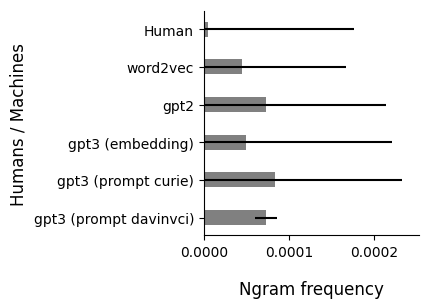

In [2]:
### stats function
def ConvertDictToDataFrame(datadict):
    #data = {'col_1': [3, 2, 1, 0], 'col_2': ['a', 'b', 'c', 'd']}    
    X = []
    Y = []
    for key in datadict.keys():
        for ele in datadict[key]:
            X.append(ele)
            Y.append(key)
        
    data = {'X': X, 'group': Y}
    df = pd.DataFrame.from_dict(data)
    return df

def outputIconForStats(pval):
    if pval <= 0.05:
        icon = '*'
    else:
        icon = ' '
    return icon

def ComputeStats_group3(data_dict):
    df = ConvertDictToDataFrame(data_dict)
    #print(df)
    mod = ols('X ~ group', data=df).fit()
    aov_table = sm.stats.anova_lm(mod, typ=2)
    
    #A one-way ANOVA revealed that there [was or was not] a statistically significant difference in [dependent variable] 
    #between at least two groups (F(between groups df, within groups df) = [F-value], p = [p-value]).
    BetweenGP_df = aov_table.df.group
    WithinGP_df = aov_table.df.Residual
    Fval = aov_table.F.group
    pval = aov_table['PR(>F)'].group
    icon = outputIconForStats(pval)
    displayStats_group3(BetweenGP_df, WithinGP_df, Fval, pval)
    return icon, BetweenGP_df, WithinGP_df, Fval, pval

def displayStats_group3(BetweenGP_df, WithinGP_df, Fval, pval):    
    print("F(" + str(BetweenGP_df) + ", " + str(WithinGP_df) + ") = " + str(Fval) +", p-val=" + str(pval))
    


def runQuery(query, start_year=2020, 
             end_year=2022, corpus=26,
             smoothing=0):
  
    # converting a regular string to 
    # the standard URL format
    # eg: "geeks for,geeks" will
    # convert to "geeks%20for%2Cgeeks"
    
    query = urllib.parse.quote(query)
    #print(query)
  
    # creating the URL
    #https://books.google.com/ngrams/json?content=Albert%20Einstein&year_start=1850&year_end=1860&corpus=26&smoothing=0
    url = 'https://books.google.com/ngrams/json?content=' + query + '&year_start=' + str(start_year) + '&year_end=' + str(end_year) + '&corpus=' + str(corpus) + '&smoothing=' + str(smoothing) + ''
    #print(url)
    # requesting data from the above url
    response = requests.get(url)
  
    # extracting the json data from the response we got
    output = response.json()
    #print(output)
  
    # creating a list to store the ngram data
    return_data = []
  
    if len(output) == 0:
        # if no data returned from site,
        # print the following statement
        return "No data available for this Ngram."
    else:
        # if data returned from site,
        # store the data in return_data list
        for num in range(len(output)):
            
              # getting the name
            return_data.append((output[num]['ngram'],                                   
                                # getting ngram data
                                output[num]['timeseries']) 
                               )
  
    return return_data

def outputNGRAM_Google(sentence):
    
    count = []
    char = sentence
    #print(char)
    #print('outouputNGRAM func')
    try:
    #print(char)
        ngram = mean(runQuery(char,start_year=2010, end_year=2020, corpus=26, smoothing=0)[0][1])
        time.sleep(1)
        #print(ngram)
        #print(ngram)
        return ngram
    except:
        print('wrong:')
        print(char)
        return 'False'
        
    #countmean = mean(count)


    
writeflag = False
if writeflag:
    
    guesswordall = []
    ngramDict = {}
    for trialid, dat in contents.items():
        cueword = dat['cue']
        guessword = dat['guess']
        agent = dat['said_by']
        guesswordall.append(guessword)
    guesswordall = list(set(guesswordall))
    print(len(guesswordall))
    
    for i, guessw in enumerate(guesswordall):
        print(i, ' ', guessw)
        measure = outputNGRAM_Google(guessw)
        #print(measure)
        ngramDict[guessw] = measure

    #initialize count
    count = {}
    for model in model_name:
        count[model] = []

    for trialid, dat in contents.items():
        cueword = dat['cue']
        guessword = dat['guess']
        agent = dat['said_by']
        
        if agent == ' gpt3 (embedding)':
            agent = 'gpt3 (embedding)'
        
        
        if CueGuessWords[cueword]['flag']:
            #count = count - 1
            #print('invalid')
            continue

        measure = ngramDict[guessword]
        #outputNGRAM_Google(guessword)
        #print(guessword)
        #measure = len(guessword)
        if isinstance(measure, str):
            print('wrong word')
        else:
            #print(measure)
            count[agent].append(measure)


    #save the compiled results as jason
    with open("./savedResults/Task2_association_ngram.json", "w") as fp:
        json.dump(count,fp) 
        
else:

    with open('./savedResults/Task2_association_ngram.json', 'r') as f:
        count = json.load(f)
    #print(count)
    

#data
#x-axis

years = list(range(1, 7))
# strtask = ['Human', 'ofa', 'git', 'clipcap', 'blip', 'microsoft_api']

['human','word2vec','gpt2','gpt3 (embedding)','gpt3 (prompt curie)','gpt3 (prompt davinvci)']
strtask = ['Human', 'word2vec','gpt2','gpt3 (embedding)','gpt3 (prompt curie)','gpt3 (prompt davinvci)']

lengths = [mean(count['human']), mean(count['word2vec']), mean(count['gpt2']), 
           mean(count['gpt3 (embedding)']), mean(count['gpt3 (prompt curie)']), mean(count['gpt3 (prompt davinvci)'])]

lengthstd = [stdev(count['human']), stdev(count['word2vec']), stdev(count['gpt2']), 
           stdev(count['gpt3 (embedding)']), stdev(count['gpt3 (prompt curie)']), stdev(count['gpt3 (prompt davinvci)'])]

strtask.reverse()
lengths.reverse()

#print(years)
#print(strtask)

# Figure Size
fig, ax = plt.subplots()

#bar chart properties
ax.barh(strtask, lengths, color ='gray', height=0.4, xerr=lengthstd)
  
plt.ylabel('Humans / Machines', fontsize=12)
plt.xlabel('Ngram frequency', fontsize=12)
plt.xticks(rotation = 0) # Rotates X-Axis Ticks by 45-degrees
ax.xaxis.set_label_coords(.5, -.2)

# plt.ylim(0, 1)
#plt.xlim(0.5, len(years)+0.5)
plt.xlim(left=0)
#draw chance 0.5 
# chancex =np.arange(len(years))
# plt.plot(chancex, np.arange(len(chancex))*0+0.5, 'k--', label='chance (50%)')
#plt.legend()
 
fig.tight_layout()

fig.set_figwidth(3.5)
fig.set_figheight(3)

fig.legend(loc='upper center', bbox_to_anchor=(0.55, 1.0), ncol=3, fancybox=True, shadow=True,frameon=False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()
#fig.savefig('./plots/Task1_caption_length.pdf', bbox_inches='tight')
fig.savefig('./plots/Task2_association_ngram.eps', format='eps', bbox_inches='tight')
fig.savefig('./plots/Task2_association_ngram.png',  bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


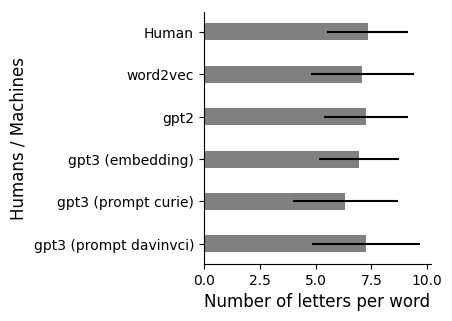

In [3]:
# #initialize count
count = {}
for model in model_name:
    count[model] = []

for trialid, dat in contents.items():
    cueword = dat['cue']
    guessword = dat['guess']
    agent = dat['said_by']
    
    if agent == ' gpt3 (embedding)':
        agent = 'gpt3 (embedding)'
    
    if CueGuessWords[cueword]['flag']:
        continue
   
    #measure = outputNGRAM_Google(guessword)
    measure = len(guessword)
    count[agent].append(measure)
    
#data
#x-axis
with open("./savedResults/Task2_association_lengths.json", "w") as fp:
    json.dump(count,fp) 
        
years = list(range(1, 7))
# strtask = ['Human', 'ofa', 'git', 'clipcap', 'blip', 'microsoft_api']

['human','word2vec','gpt2','gpt3 (embedding)','gpt3 (prompt curie)','gpt3 (prompt davinvci)']
strtask = ['Human', 'word2vec','gpt2','gpt3 (embedding)','gpt3 (prompt curie)','gpt3 (prompt davinvci)']

lengths = [mean(count['human']), mean(count['word2vec']), mean(count['gpt2']), 
           mean(count['gpt3 (embedding)']), mean(count['gpt3 (prompt curie)']), mean(count['gpt3 (prompt davinvci)'])]

lengthstd = [stdev(count['human']), stdev(count['word2vec']), stdev(count['gpt2']), 
           stdev(count['gpt3 (embedding)']), stdev(count['gpt3 (prompt curie)']), stdev(count['gpt3 (prompt davinvci)'])]

strtask.reverse()
lengths.reverse()

#print(years)
#print(strtask)

# Figure Size
fig, ax = plt.subplots()

#bar chart properties
ax.barh(strtask, lengths, color ='gray', height=0.4, xerr=lengthstd)
  
plt.ylabel('Humans / Machines', fontsize=12)
plt.xlabel('Number of letters per word', fontsize=12)
plt.xticks(rotation = 0) # Rotates X-Axis Ticks by 45-degrees
plt.xlim(left=0)
# plt.ylim(0, 1)
#plt.xlim(0.5, len(years)+0.5)

#draw chance 0.5 
# chancex =np.arange(len(years))
# plt.plot(chancex, np.arange(len(chancex))*0+0.5, 'k--', label='chance (50%)')
#plt.legend()
 
fig.tight_layout()

fig.set_figwidth(3.5)
fig.set_figheight(3)

fig.legend(loc='upper center', bbox_to_anchor=(0.55, 1.0), ncol=3, fancybox=True, shadow=True,frameon=False)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()
#fig.savefig('./plots/Task1_caption_length.pdf', bbox_inches='tight')
fig.savefig('./plots/Task2_association_lengths.eps', format='eps', bbox_inches='tight')
fig.savefig('./plots/Task2_association_lengths.png',  bbox_inches='tight')

In [4]:
with open('./savedResults/Task2_association_ngram.json', 'r') as f:
        count = json.load(f)

print('Task2_association_ngram')
ComputeStats_group3(count)


with open('./savedResults/Task2_association_lengths.json', 'r') as f:
        count = json.load(f)
        
print('Task2_association_lengths')
ComputeStats_group3(count)

Task2_association_ngram
F(5.0, 824.0) = 14.482294377974162, p-val=1.2835558926157883e-13
Task2_association_lengths
F(5.0, 824.0) = 2.940560191261965, p-val=0.012217261429258403


('*', 5.0, 824.0, 2.940560191261965, 0.012217261429258403)